<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

Все необходимые пакеты для выполнения заданий

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, precision_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve
    
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

Все необходимые константы и структуры данных для выполнения заданий

In [2]:
depth_range = range(1,20)
n_trees_range = range(10,101,10)
th = 0.5
classification_metrics = {'f1': f1_score, 
                          'recall': recall_score, 
                          'precision': precision_score, 
                          'accuracy': accuracy_score,
                          'roc_auc': roc_auc_score
                         }

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [4]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df_wine.quality = (df_wine.quality > 5).astype(int)
train_df, test_df = train_test_split(df_wine, test_size=0.2, random_state=123)
X_columns = df_wine.columns.drop('quality')
X_train, y_train = train_df[X_columns], train_df.quality
X_test, y_test = test_df[X_columns], test_df.quality

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

Подбор наилучшей глубины d дерева с помощью усредненной оценки качества roc-auc на кросс-валидации при различных d

Best depth is 4


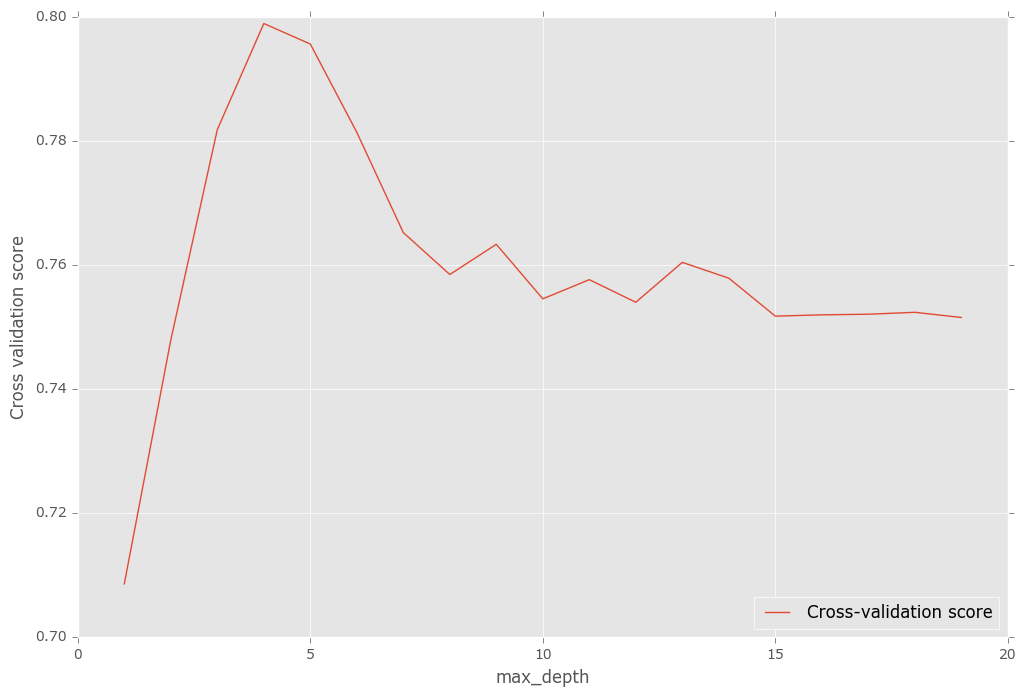

In [5]:
best_depth = 1
max_mean_score = 0.0
means = []
for depth in depth_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=123)
    tmp_mean = cross_val_score(tree, X_train, y_train, cv=5, scoring='roc_auc').mean()
    means.append(tmp_mean)
    if tmp_mean > max_mean_score:
        best_depth = depth
        max_mean_score = tmp_mean
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Best depth is", best_depth

plt.figure()
plt.plot(range(1,20), means, label="Cross-validation score")
plt.xlabel('max_depth')
plt.ylabel('Cross validation score')
plt.legend(loc="lower right")
plt.show()

Подбор наилучшей глубины d дерева с помощью валидационных кривых

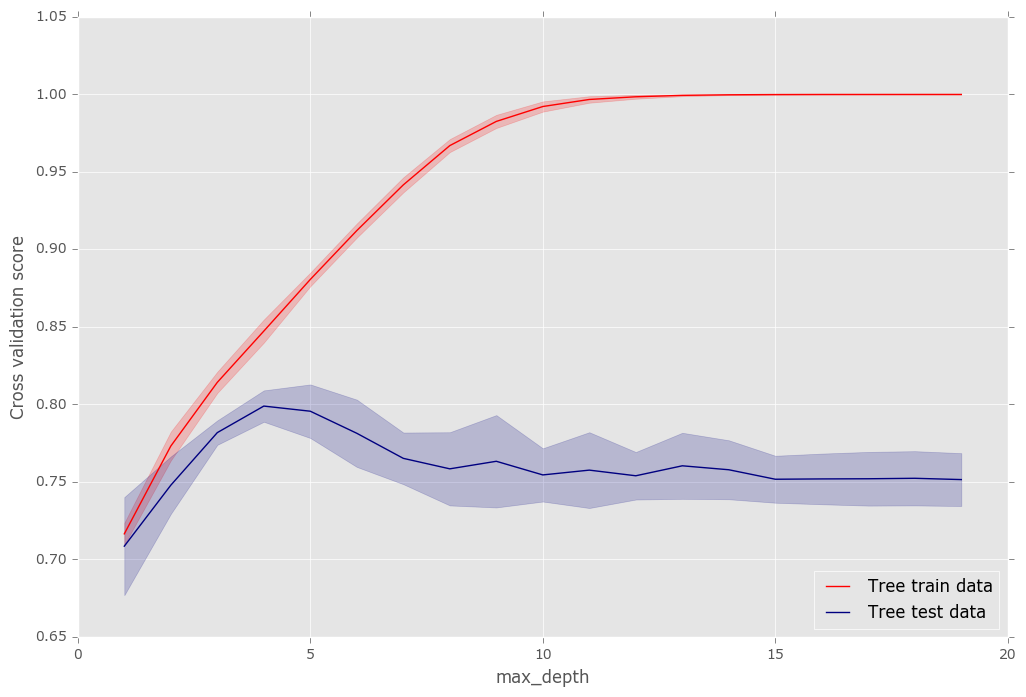

In [6]:
tree = DecisionTreeClassifier(max_depth=best_depth, random_state=123)
train_score, test_score = validation_curve(tree, X_train, y_train, 'max_depth', range(1,20), scoring='roc_auc', cv=5)
train_score.shape

mean_train = np.mean(train_score, axis=1)
std_train = np.std(train_score, axis=1)
mean_test = np.mean(test_score, axis=1)
std_test = np.std(test_score, axis=1)
plt.plot(depth_range, mean_train, color="red", label="Tree train data")
plt.plot(depth_range, mean_test, color="navy", label="Tree test data")
plt.fill_between(depth_range, mean_train - std_train, mean_train + std_train, alpha=0.2, color='red')
plt.fill_between(depth_range, mean_test - std_test, mean_test + std_test, alpha=0.2, color="navy")
plt.xlabel('max_depth')
plt.ylabel('Cross validation score')
plt.legend(loc="lower right")
plt.show()

Кривая на тестовой выборке начинает идти вниз после глубины 4 и расходиться с кривой на обучающей выборке, которая уходит вверх, что говорит о переобучении деревом с большой глубиной. При этом на 4 достигается максимум на тестовой кривой. Следовательно, в качестве лучшего параметра стоит взять глубину 4.
Примечание: в зависимости от разбиение на обучающую и тестовую выборки, оптимальная глубина дерева может быть 4 или 5, если не фиксировать random_state для разбиения на train_test_split.

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [7]:
tree = DecisionTreeClassifier(max_depth=best_depth, random_state=123)
tree.fit(X_train, y_train)
importances = tree.feature_importances_
importances = sorted(range(len(importances)), key=lambda k: importances[k], reverse=True)
print "List of features, most important features first"
for idx, feature in enumerate(df_wine.columns[importances], 1):
    print idx, feature, tree.feature_importances_[importances[idx - 1]]

List of features, most important features first
1 alcohol 0.574585615363
2 sulphates 0.160579942473
3 volatile acidity 0.126479368644
4 total sulfur dioxide 0.054715792374
5 free sulfur dioxide 0.0522639831825
6 pH 0.0178117723373
7 density 0.013563525626
8 fixed acidity 0.0
9 citric acid 0.0
10 residual sugar 0.0
11 chlorides 0.0


#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

Получение предсказаний на тестовой выборке и построение ROC кривых для обучающей и тестовой выборок

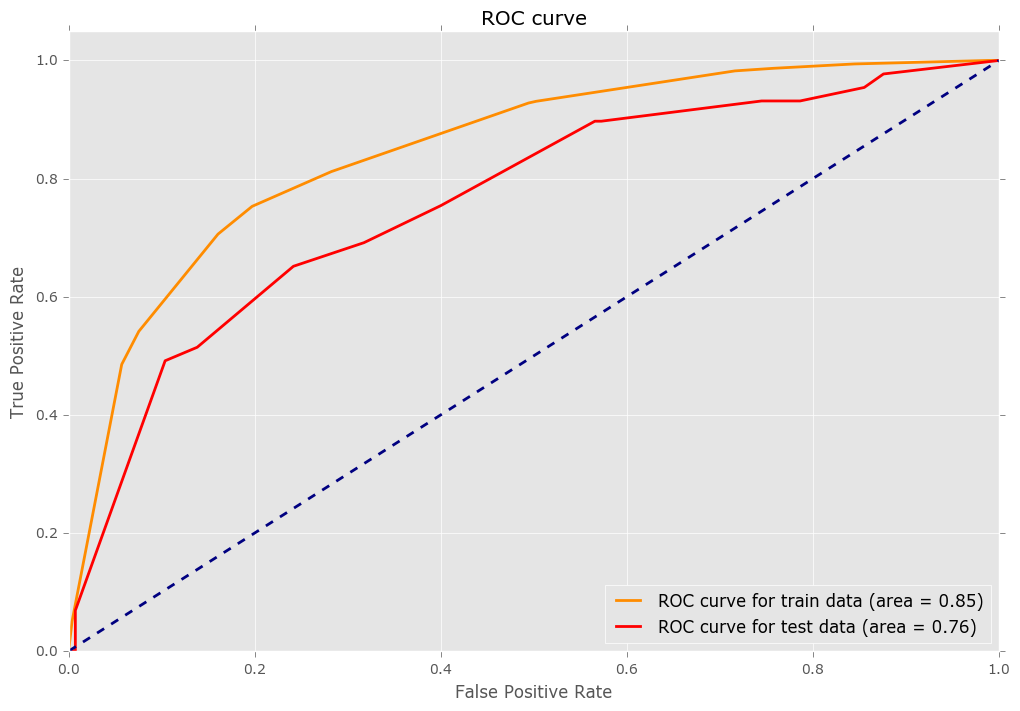

In [8]:
tree = DecisionTreeClassifier(max_depth=best_depth, random_state=123)
tree.fit(X_train, y_train)
predicted_test = tree.predict_proba(X_test)[:,1]
predicted_train = tree.predict_proba(X_train)[:,1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predicted_test)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predicted_train)
roc_auc_train = auc(fpr_train, tpr_train)


plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red',
         lw=lw, label='ROC curve for test data (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Подсчёт остальных мер качества классификации при пороге в 0.5

In [9]:
predicted_test_th = (predicted_test >= th).astype(int)

for metric in classification_metrics:
    print metric + ":\t" + classification_metrics[metric](y_test, predicted_test_th).astype(str)

f1:	0.707602339181
roc_auc:	0.687093596059
accuracy:	0.6875
precision:	0.724550898204
recall:	0.691428571429


#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [10]:
tree = DecisionTreeClassifier(max_depth=best_depth, random_state=123)
bagging = BaggingClassifier(base_estimator=tree, random_state=123)
random_forest = RandomForestClassifier(max_depth=best_depth, random_state=123)

train_scores_bagging, test_scores_bagging = validation_curve(bagging, X_train, y_train, 'n_estimators', n_trees_range, 
                                                             scoring='roc_auc', cv=5)
train_scores_random_forest, test_scores_random_forest = validation_curve(random_forest, X_train, y_train, 'n_estimators', 
                                                                         n_trees_range, scoring='roc_auc', cv=5)

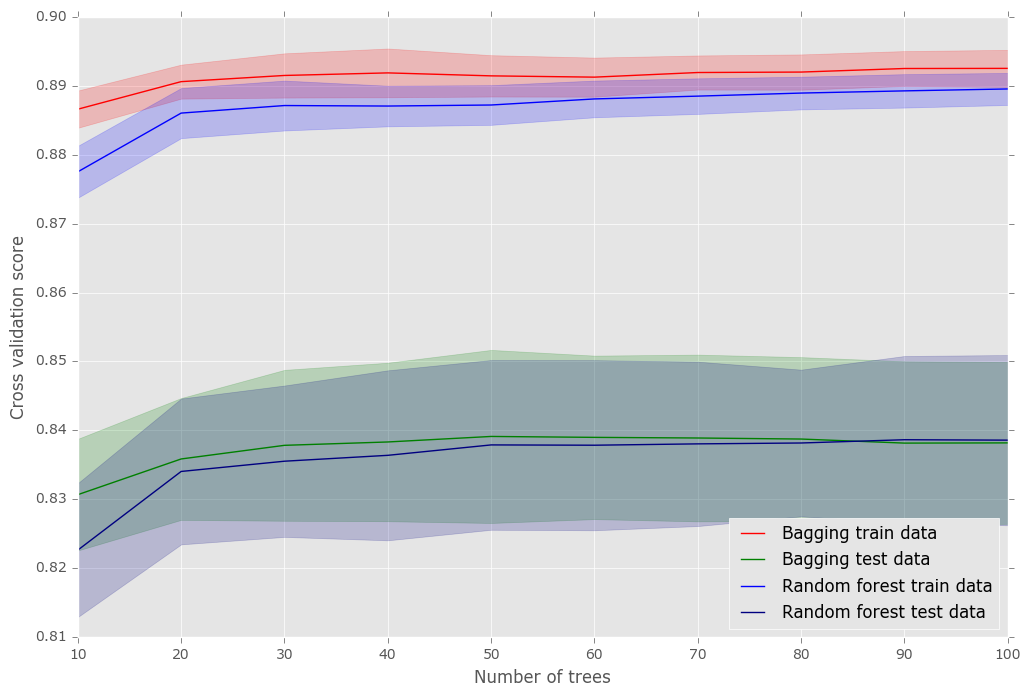

In [11]:
mean_train_bagging = np.mean(train_scores_bagging, axis=1)
std_train_bagging = np.std(train_scores_bagging, axis=1)
mean_test_bagging = np.mean(test_scores_bagging, axis=1)
std_test_bagging = np.std(test_scores_bagging, axis=1)

mean_train_random_forest = np.mean(train_scores_random_forest, axis=1)
std_train_random_forest = np.std(train_scores_random_forest, axis=1)
mean_test_random_forest = np.mean(test_scores_random_forest, axis=1)
std_test_random_forest = np.std(test_scores_random_forest, axis=1)

plt.plot(n_trees_range, mean_train_bagging, color='red', label='Bagging train data')
plt.plot(n_trees_range, mean_test_bagging, color='green', label='Bagging test data')
plt.plot(n_trees_range, mean_train_random_forest, color='blue', label='Random forest train data')
plt.plot(n_trees_range, mean_test_random_forest, color='navy', label='Random forest test data')

plt.fill_between(n_trees_range, mean_train_bagging - std_train_bagging, mean_train_bagging + std_train_bagging, alpha=0.2, 
                 color='red')
plt.fill_between(n_trees_range, mean_test_bagging - std_test_bagging, mean_test_bagging + std_test_bagging, alpha=0.2, 
                 color='green')
plt.fill_between(n_trees_range, mean_train_random_forest -std_train_random_forest, 
                 mean_train_random_forest + std_train_random_forest, alpha=0.2, color='blue')
plt.fill_between(n_trees_range, mean_test_random_forest - std_test_random_forest, 
                 mean_test_random_forest + std_test_random_forest, alpha=0.2, color='navy')
plt.legend("Validation curves for bagging and random forest")
plt.xlabel('Number of trees')
plt.ylabel('Cross validation score')
plt.legend(loc="lower right")
plt.show()

Сравнение качества классификации с помощью bagging и random forest 

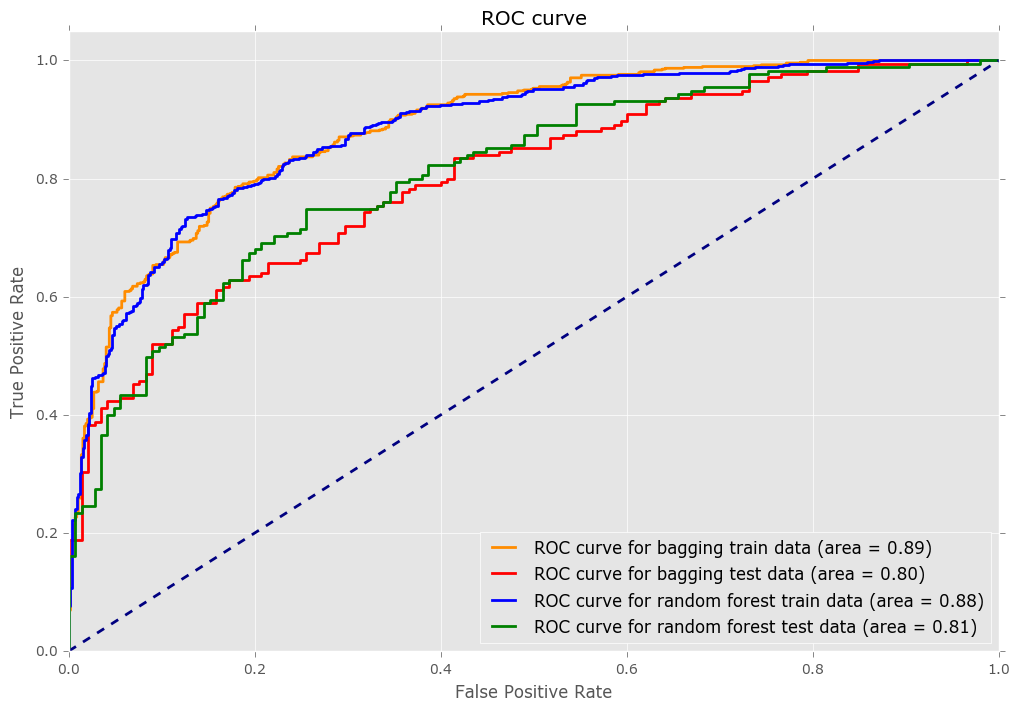

Classification quality in different metrics with classification threshold = 0.5 for Bagging and Random Forest
f1:	bagging:	0.740947075209	random forest:	0.741573033708
roc_auc:	bagging:	0.704137931034	random forest:	0.708177339901
accuracy:	bagging:	0.709375	random forest:	0.7125
precision:	bagging:	0.722826086957	random forest:	0.729281767956
recall:	bagging:	0.76	random forest:	0.754285714286


In [12]:
bagging_best_n_trees = 100
random_forest_best_n_trees = 90

tree = DecisionTreeClassifier(max_depth=best_depth, random_state=123)
bagging = BaggingClassifier(base_estimator=tree, n_estimators=bagging_best_n_trees, random_state=123)
random_forest = RandomForestClassifier(max_depth=best_depth, n_estimators=random_forest_best_n_trees, random_state=123)

bagging.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

predicted_test_bagging = bagging.predict_proba(X_test)[:,1]
predicted_train_bagging = bagging.predict_proba(X_train)[:,1]
predicted_test_random_forest = random_forest.predict_proba(X_test)[:,1]
predicted_train_random_forest = random_forest.predict_proba(X_train)[:,1]

fpr_test_bagging, tpr_test_bagging, thresholds_test_bagging = roc_curve(y_test, predicted_test_bagging)
roc_auc_test_bagging = auc(fpr_test_bagging, tpr_test_bagging)
fpr_train_bagging, tpr_train_bagging, thresholds_train_bagging = roc_curve(y_train, predicted_train_bagging)
roc_auc_train_bagging = auc(fpr_train_bagging, tpr_train_bagging)

fpr_test_random_forest, tpr_test_random_forest, thresholds_test_random_forest = roc_curve(y_test, predicted_test_random_forest)
roc_auc_test_random_forest = auc(fpr_test_random_forest, tpr_test_random_forest)
fpr_train_random_forest, tpr_train_random_forest, thresholds_train_random_forest = roc_curve(y_train, predicted_train_random_forest)
roc_auc_train_random_forest = auc(fpr_train_random_forest, tpr_train_random_forest)


plt.figure()
lw = 2
plt.plot(fpr_train_bagging, tpr_train_bagging, color='darkorange',
         lw=lw, label='ROC curve for bagging train data (area = %0.2f)' % roc_auc_train_bagging)
plt.plot(fpr_test_bagging, tpr_test_bagging, color='red',
         lw=lw, label='ROC curve for bagging test data (area = %0.2f)' % roc_auc_test_bagging)
plt.plot(fpr_train_random_forest, tpr_train_random_forest, color='blue',
         lw=lw, label='ROC curve for random forest train data (area = %0.2f)' % roc_auc_train_random_forest)
plt.plot(fpr_test_random_forest, tpr_test_random_forest, color='green',
         lw=lw, label='ROC curve for random forest test data (area = %0.2f)' % roc_auc_test_random_forest)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

th = 0.5
predicted_test_th_bagging = (predicted_test_bagging >= th).astype(int)
predicted_test_th_random_forest = (predicted_test_random_forest >= th).astype(int)



print "Classification quality in different metrics with classification threshold = 0.5 for Bagging and Random Forest"
for metric in classification_metrics:
    print metric + ":\tbagging:\t" + classification_metrics[metric](y_test, predicted_test_th_bagging).astype(str) + \
    "\trandom forest:\t" + classification_metrics[metric](y_test, predicted_test_th_random_forest).astype(str)

Как видно из валидационных кривых, бэггинг немного  сильнее переобучается, однако качество классификации на тестовой выборке у случайного леса немного больше. Однако, различия не существенные. Для получения хорошего качества классификации достаточно 20-30 деревьев для бэггинга, и 40-50 деревьев для случайного леса.
Если сравнить с результатами для одного дерева, то бэггинг и случайный лес показывают более хорошие результаты (сравнение проводилось при пороге классификации 0.5 и наилучших подобранных параметров для каждой модели).

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

Подбор наиболее оптимальных параметров для случайного леса с помощью GridSearchCV

In [13]:
random_forest = RandomForestClassifier(random_state=123)
grid = {'n_estimators': n_trees_range, 'max_depth': depth_range}
grid_cv = GridSearchCV(random_forest, grid, 'roc_auc', cv=5)
grid_cv.fit(X_train, y_train)
print grid_cv.best_params_

{'n_estimators': 90, 'max_depth': 16}


Сравнение средних результатов по кросс-валидации и качества на контрольной выборке для найденных лучших параметров

In [14]:
best_forest = grid_cv.best_estimator_
predicted = best_forest.predict(X_test)
predicted_scores = best_forest.predict_proba(X_test)[:,1]

for metric in classification_metrics:
    if metric != 'roc_auc':
        print metric + ":\t" + \
        "cross-val on train:\t" + cross_val_score(best_forest, X_train, y_train, scoring=metric, cv=5).mean().astype(str) + \
        "\ton test:\t" + classification_metrics[metric](y_test, predicted).astype(str)
    else:
        print metric + ":\t" + \
        "cross-val on train:\t" + cross_val_score(best_forest, X_train, y_train, scoring=metric, cv=5).mean().astype(str) + \
        "\ton test:\t" + classification_metrics[metric](y_test, predicted_scores).astype(str)

f1:	cross-val on train:	0.834486530447	on test:	0.825842696629
roc_auc:	cross-val on train:	0.889694966222	on test:	0.87842364532
accuracy:	cross-val on train:	0.822503063725	on test:	0.80625
precision:	cross-val on train:	0.828176246308	on test:	0.812154696133
recall:	cross-val on train:	0.841176470588	on test:	0.84


Видно, что оценки на тестовой выборке практически такие же, как и на обучающей выборке, что говорит об отсутствии переобучения.
Оценки от 80% говорят о том, что недообучения также не произошло.